My goal is to create a chess engine based on convolutional neural nets and reinforcement learning.  But first I will try to answer the question "can convnets learn useful features to represent chess positions".  In this notebook, I will train autoencoders on chess positions and attempt to find neurons that have learned semantically meaningful features.

In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import chess
import chess.pgn
import math

import numpy as np
import tensorflow as tf

from utils import *

# Load data

In [4]:
pgnf = open("data/ficsgamesdb_201701_standard_nomovetimes_1482388.pgn")
X = []
for i in range(100):
    game = chess.pgn.read_game(pgnf)
    boards = get_boards_from_game(game)
    for board in boards:
        X.append(board_to_arr(board))
X = np.array(X)

## Train

In [51]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
x_flat = tf.placeholder("float", [None, 8 * 8 * 6])
x = tf.placeholder("float", [None, 8, 8, 6])
autoencoder1 = create(x_flat, [60, 30, 20])
cae = create_cae(x, [20, 10])

In [52]:
def train(autoencoder):
    train_step = tf.train.AdamOptimizer(0.001).minimize(autoencoder['cost'])

    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(20000):
        inds = np.random.choice(X.shape[0], 100)
        X_batch = X[inds]
#         X_batch = np.reshape(X_batch, (100, -1))
        sess.run(train_step, feed_dict={x: X_batch})
        if i % 1000 == 0:
            print(i, " cost", sess.run(autoencoder['cost'], feed_dict={x:  X_batch}))

In [53]:
train(cae)

0  cost 0.559892
1000  cost 0.259975
2000  cost 0.254857
3000  cost 0.244033
4000  cost 0.237509
5000  cost 0.241757
6000  cost 0.239732
7000  cost 0.237376
8000  cost 0.240676
9000  cost 0.243145
10000  cost 0.243445
11000  cost 0.239926
12000  cost 0.234831
13000  cost 0.242284
14000  cost 0.244849
15000  cost 0.238844
16000  cost 0.23661
17000  cost 0.243008
18000  cost 0.24027
19000  cost 0.240945


In [54]:
evalSet = X[:100]

decodedLong = sess.run(cae['decoded'], feed_dict={x: evalSet})

decoded = np.reshape(decodedLong, (100,8,8,6))

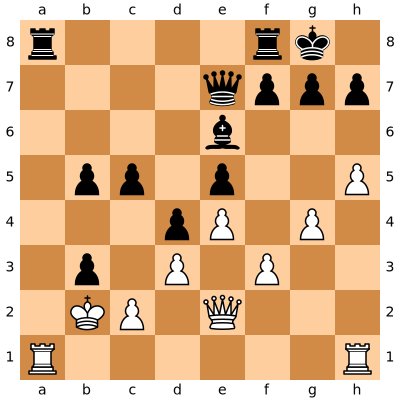

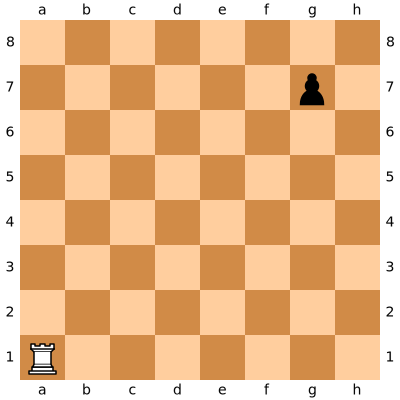

In [57]:
arr_to_board(X[45])
arr_to_board(decoded[45])

In [56]:
np.sum(quantize_arr_vec(decoded) != evalSet) / decoded.size

0.072213541666666672

In [ ]:
evalSet = X[:100]

decodedLong = sess.run(autoencoder2['decoded'], feed_dict={x: np.reshape(evalSet, (100, -1))})

decoded = np.reshape(decodedLong, (100,8,8,6))

In [ ]:
np.sum(quantize_arr_vec(decoded) != evalSet) / decoded.size

In [ ]:
arr_to_board(decoded[40])
arr_to_board(X[40])

# Come back to this later

In [ ]:
neuron = autoencoder['encoded'][0][5]
neuron_grad = tf.gradients(neuron, x)

# board = np.zeros((8,8,6))
board = np.random.normal(size=(8,8,6), scale=.1)
print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

for i in range(10000):
    grad = sess.run(neuron_grad, feed_dict={x: np.reshape(board, (1, -1))})[0]
    grad = np.reshape(grad, (8,8,6))
    board += 1e-3 * grad
    board[board > 1] = 1
    board[board < -1] = -1
    
    if i % 1000 == 0:
        print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

In [ ]:
arr_to_board(board)

In [ ]:
board